In [34]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, sobel, convolve
import matplotlib.pyplot as plt
import os

def HarrisPointsDetector(image, sigma=0.5, k=0.05, thresh=0.045):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray) / 255.0

    gray = (gray - np.mean(gray)) / np.std(gray)
    
    # Compute x and y derivatives using Sobel operator
    dx = sobel(gray, axis=1, mode='reflect')
    dy = sobel(gray, axis=0, mode='reflect')
    
    # Compute products of derivatives
    Ixx = dx**2
    Ixy = dx*dy
    Iyy = dy**2
    
    # Apply Gaussian filter to the products of derivatives
    Ixx = gaussian_filter(Ixx, sigma, mode='reflect')
    Ixy = gaussian_filter(Ixy, sigma, mode='reflect')
    Iyy = gaussian_filter(Iyy, sigma, mode='reflect')
    
    # Compute the Harris matrix M and corner response function R
    detM = Ixx * Iyy - Ixy ** 2
    traceM = Ixx + Iyy
    R = detM - k * (traceM ** 2)

    local_max = (R == maximum_filter(R, size=7, mode='reflect'))
    
    # Apply non-maximum suppression to find local maxima
    threshold = threshold * R.max()
    keypoints = np.argwhere((R > threshold) & local_max)

    orientation = np.rad2deg(np.arctan2(dy, dx)) % 360

    # Convert to OpenCV keypoint format and compute orientation
    keypoints_cv = [cv2.KeyPoint(float(x[1]), float(x[0]), 20, angle=float(orientation[x[0], x[1]]))
                    for x in keypoints]
    
    return keypoints_cv

def featureDescriptor(image, keypoints):
  # sift = cv2.SIFT_create()

  # keypoints, descriptors = sift.compute(image, keypoints)

  orb = cv2.ORB_create()
  keypoints, descriptors = orb.compute(image, keypoints)

  return descriptors

In [ ]:
from scipy.ndimage import gaussian_filter, sobel, maximum_filter, convolve

def HarrisPointsDetector(image, threshold ):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

    # gray = np.pad(gray, ((1, 1), (1, 1)), 'reflect')
    # print(gray_padded)
    # Compute x and y derivatives using the Sobel operator
    Ix = sobel(gray, axis=1, mode='reflect') # 1 for x-axis
    Iy = sobel(gray, axis=0, mode='reflect') # 0 for y-axis

    # Calculate the products of derivatives at each pixel
    Ixx = Ix ** 2
    Ixy = Ix * Iy
    Iyy = Iy ** 2

    # Create a Gaussian window of 5x5 with sigma 0.5
    gaussian_weights = cv2.getGaussianKernel(ksize=5, sigma=0.5)
    gaussian_weights = np.outer(gaussian_weights, gaussian_weights)
    # print(gaussian_weights)

    # Apply the Gaussian window to smooth the products of derivatives
    # GIxx = gaussian_filter(Ixx, sigma=0.5, mode='reflect')
    # GIxy = gaussian_filter(Ixy, sigma=0.5, mode='reflect')
    # GIyy  = gaussian_filter(Iyy, sigma=0.5, mode='reflect')
    GIxx = convolve(Ixx, gaussian_weights, mode='reflect')
    GIxy = convolve(Ixy, gaussian_weights, mode='reflect')
    GIyy = convolve(Iyy, gaussian_weights, mode='reflect')

    # Compute the Harris response for each pixel
    det = (GIxx * GIyy) - (GIxy ** 2)
    trace = GIxx + GIyy
    R = det - 0.05 * (trace ** 2)

    # Non-maximum suppression with a 7x7 window
    local_max = (R == maximum_filter(R, size=7, mode='reflect'))

    # Define the threshold for an interest point
    threshold = threshold * R.max()
    keypoints = np.argwhere((R > threshold) & local_max)

    orientations = np.arctan2(Iy, Ix)

    # Gather keypoints with their orientations
    keypoints_cv = [cv2.KeyPoint(float(kp[1]), float(kp[0]), _size=1, _angle=orientations[kp[0], kp[1]])
                    for kp in keypoints]

    return keypoints_cv

In [29]:
# ref_img_path = 'reference_image/bernieSanders.jpg'
# ref_img = cv2.imread(ref_img_path)

# benchmark_dir = 'COMP37212'
# benchmark_image_files = [f for f in os.listdir(benchmark_dir) if os.path.isfile(os.path.join(benchmark_dir, f))]

# threshold_values = np.linspace(0.1, 0.3, 50)

# num_images = len(benchmark_image_files) + 1
# num_cols = 2
# num_rows = (num_images + 1) // num_cols

# plt.figure(figsize=(20, 5 * num_rows))

# # Compute keypoint detection for the reference image
# ref_num_keypoints_custom = []

# for threshold in threshold_values:
#     ref_keypoints_custom = HarrisPointsDetector(ref_img, sigma=0.5, thresh=threshold)
#     ref_num_keypoints_custom.append(len(ref_keypoints_custom))

# plt.subplot(num_rows, num_cols, 1)
# plt.plot(threshold_values, ref_num_keypoints_custom, marker='o', label='Custom Harris Detector')
# plt.xlabel('Threshold Value')
# plt.ylabel('Number of Keypoints Detected')
# plt.title('Reference Image')
# plt.legend()
# plt.grid(True)

# # Compute keypoint detection for each benchmark image
# for num_image, benchmark_image_file in enumerate(benchmark_image_files):
#     benchmark_image_path = os.path.join(benchmark_dir, benchmark_image_file)
#     benchmark_img = cv2.imread(benchmark_image_path)

#     benchmark_num_keypoints_custom = []

#     for threshold in threshold_values:
#         benchmark_keypoints_custom = HarrisPointsDetector(benchmark_img, sigma=0.5, thresh=threshold)
#         benchmark_num_keypoints_custom.append(len(benchmark_keypoints_custom))

#     plt.subplot(num_rows, num_cols, num_image + 2)
#     plt.plot(threshold_values, benchmark_num_keypoints_custom, marker='o', label='Custom Harris Detector')
#     plt.xlabel('Threshold Value')
#     plt.ylabel('Number of Keypoints Detected')
#     plt.title(f'Benchmark Image {num_image+1}')
#     plt.legend()
#     plt.grid(True)

# plt.tight_layout()
# plt.show()

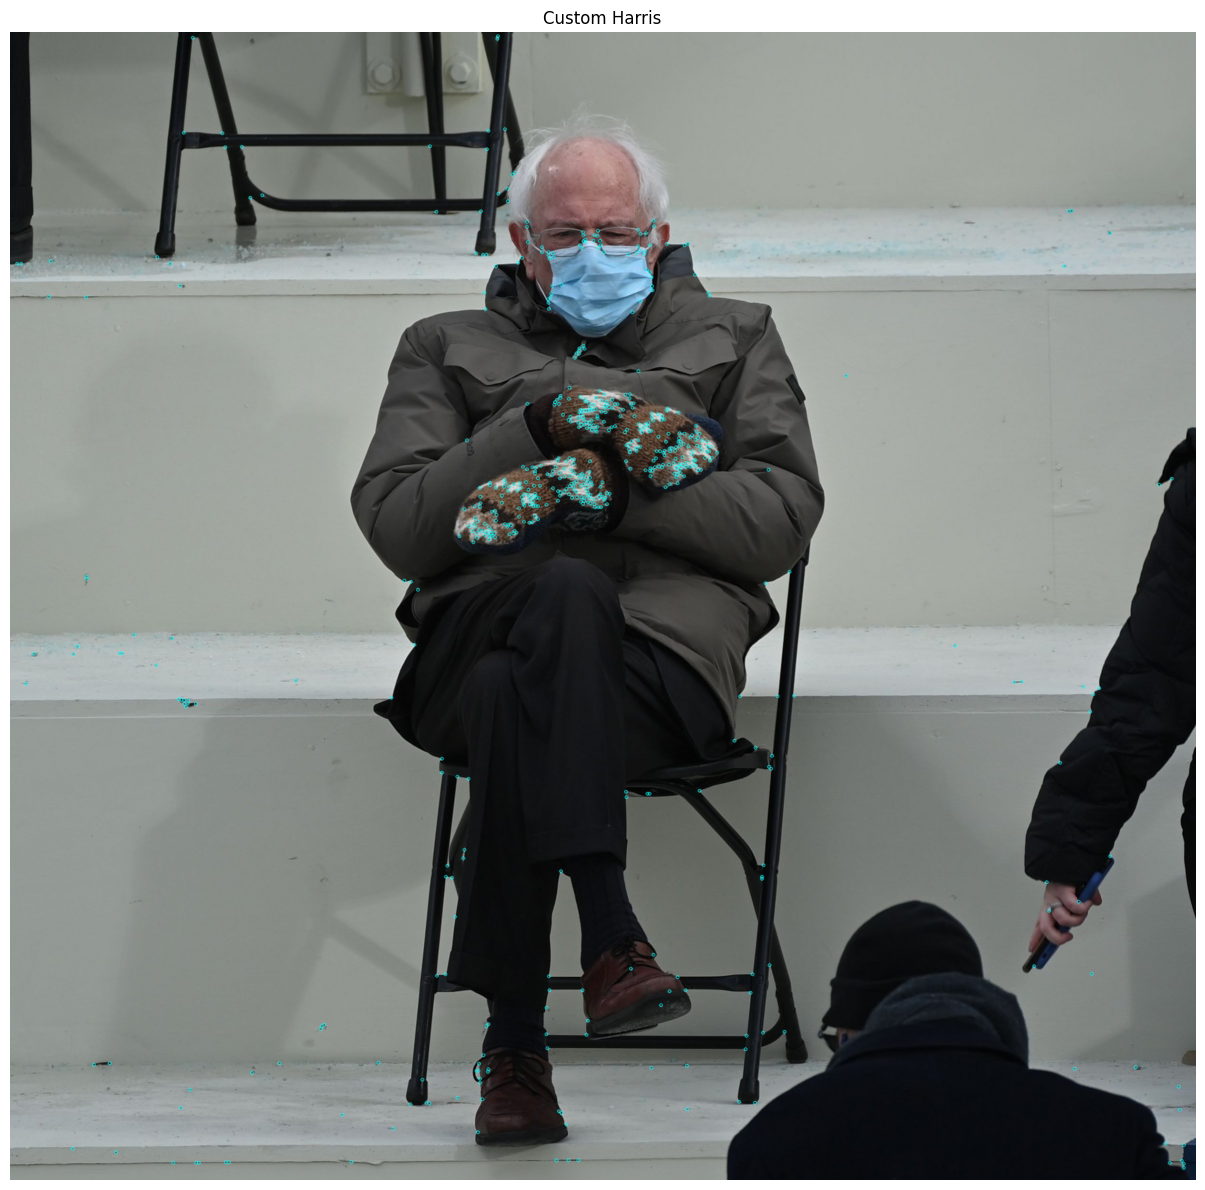

Number of keypoints detected by Harris: 615


In [35]:
ref_img_path = 'COMP37212/bernieSanders.jpg'
ref_img = cv2.imread(ref_img_path)

ref_keypoints = HarrisPointsDetector(ref_img, thresh=0.01)
ref_img_with_keypoints = cv2.drawKeypoints(ref_img, ref_keypoints, None, color=(255, 255, 0))
ref_img_with_keypoints_rgb = cv2.cvtColor(ref_img_with_keypoints, cv2.COLOR_BGR2RGB)

# Create an instance of ORB detector with FAST keypoints
orb_fast = cv2.ORB_create()

# Create another instance of ORB detector with Harris corners
orb_harris = cv2.ORB_create(scoreType=cv2.ORB_HARRIS_SCORE)

kp_fast = orb_fast.detect(ref_img, None)
kp_harris = orb_harris.detect(ref_img, None)

_, descriptors_FAST = orb_fast.compute(ref_img, kp_fast)
_, descriptors_Harris = orb_harris.compute(ref_img, kp_harris)

image_orb_harris = cv2.drawKeypoints(ref_img, kp_harris, None, color=(255, 255, 0))
image_orb_fast = cv2.drawKeypoints(ref_img, kp_fast, None, color=(255, 255, 0))

# Convert to RGB for Matplotlib
image_orb_harris_rgb = cv2.cvtColor(image_orb_harris, cv2.COLOR_BGR2RGB)
image_orb_fast_rgb = cv2.cvtColor(image_orb_fast, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(24, 12))

# plt.subplot(1, 3, 1)
plt.imshow(ref_img_with_keypoints_rgb)
plt.title('Custom Harris')
plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(image_orb_harris_rgb)
# plt.title('ORB Harris')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.imshow(image_orb_fast_rgb)
# plt.title('ORB FAST')
# plt.axis('off')

plt.tight_layout()
plt.show()

print(f'Number of keypoints detected by Harris: {len(ref_keypoints)}')

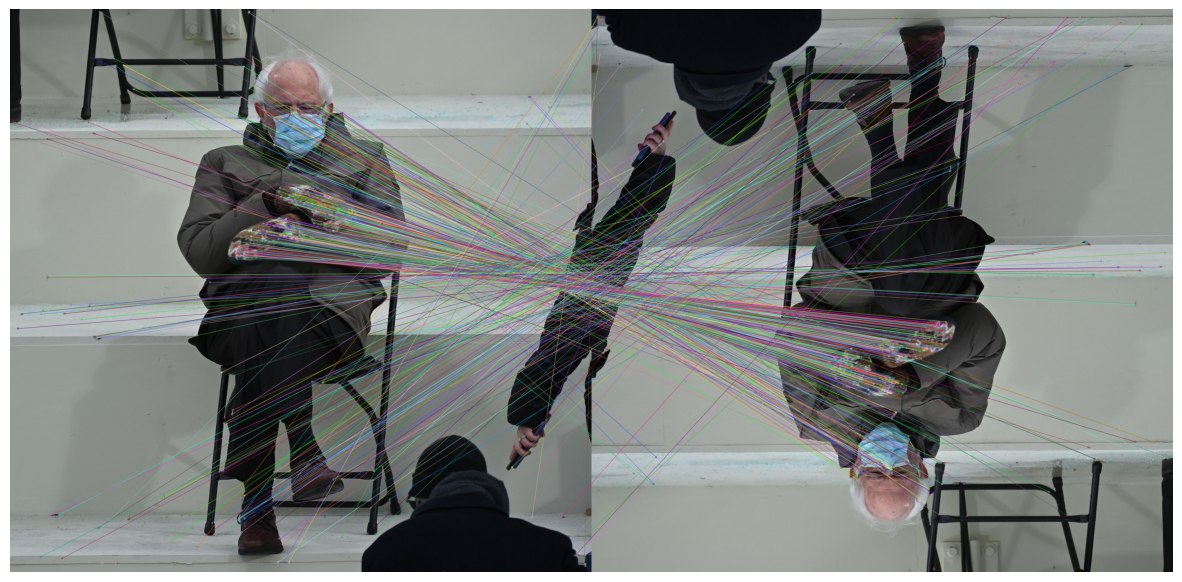

Image: COMP37212/bernie180.jpg
Number of matches: 606


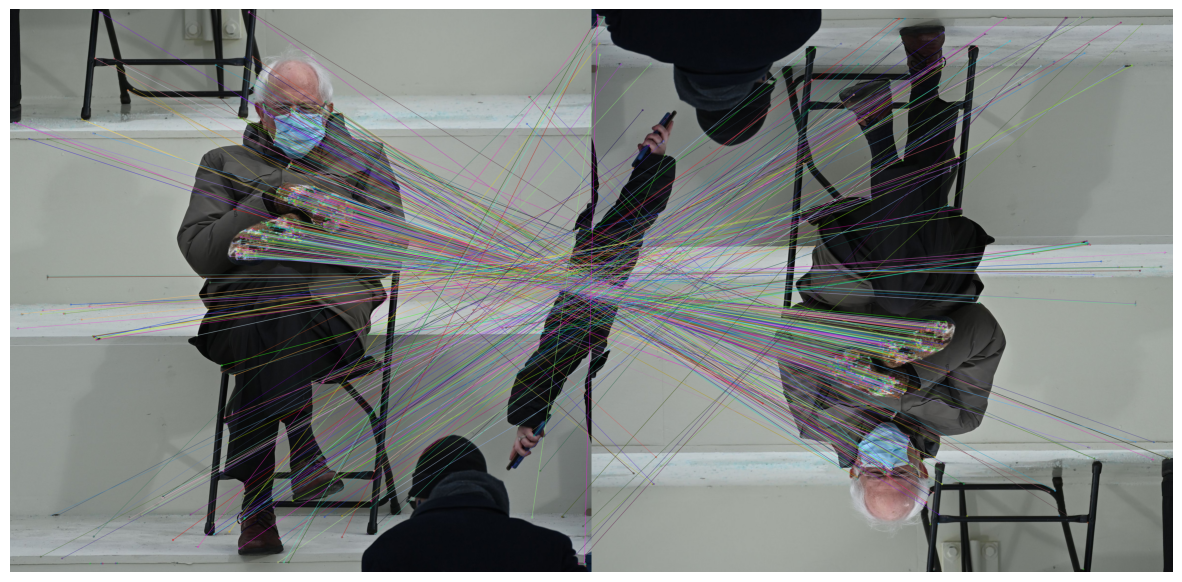

Image: COMP37212/bernie180.jpg
Number of matches: 606


In [39]:
from scipy.spatial.distance import cdist

def calculate_ssd(des1, des2):
  ssd_matrix = cdist(des1, des2, 'sqeuclidean')  # 'sqeuclidean' computes the squared Euclidean distance
  return ssd_matrix

def ssd_matcher(ssd_matrix, ssd_threshold):
  matches = []
  for i, ssds in enumerate(ssd_matrix):
      closest = np.argmin(ssds)
      
      if ssds[closest] < ssd_threshold:
          matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=closest, _distance=ssds[closest]))

  return matches

def ratio_test(ssd_matrix, threshold):
  matches = []
  for i, ssds in enumerate(ssd_matrix):
    sorted_indices = np.argsort(ssds)
    closest, second_closest = sorted_indices[:2]

    if ssds[closest] <= 100.0 and ssds[closest] / ssds[second_closest] < threshold:
      # Append a cv2.DMatch object to the list of matches
      matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=closest, _distance=ssds[closest]))

  return matches

orb = cv2.ORB_create()

benchmark_image_path = 'COMP37212/bernie180.jpg'
benchmark_img = cv2.imread(benchmark_image_path)
ref_img = cv2.imread('reference_image/bernieSanders.jpg')

kp_ref = HarrisPointsDetector(ref_img, thresh=0.01)
des_ref = orb.conmpute(ref_img, kp_ref)

kp_benchmark = HarrisPointsDetector(benchmark_img, thresh=0.01)
des
ssd_matrix = calculate_ssd(des_ref, des_benchmark)


# ratio matches
ratio_matches = ratio_test(ssd_matrix, threshold=0.9)

matched_img = cv2.drawMatches(ref_img, kp_ref, benchmark_img, kp_benchmark, ratio_matches, None)
matched_img_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))  # You can adjust the figure size as needed
plt.imshow(matched_img_rgb)
plt.axis('off')  # Hide the axis
plt.show()

print(f"Image: {benchmark_image_path}")
print(f"Number of matches: {len(ratio_matches)}")


# ssd matches
ssd_matches = ssd_matcher(ssd_matrix, ssd_threshold=100.0)
matched_img_ssd = cv2.drawMatches(ref_img, kp_ref, benchmark_img, kp_benchmark, ssd_matches, None)
matched_img_ssd_rgb = cv2.cvtColor(matched_img_ssd, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))  # You can adjust the figure size as needed
plt.imshow(matched_img_ssd_rgb)
plt.axis('off')  # Hide the axis
plt.show()

print(f"Image: {benchmark_image_path}")
print(f"Number of matches: {len(ssd_matches)}")